# Metrics

Comparing data distributions
- Generator -> reconstructions - examine movement
- Reconstructions -> target model - identify effectiveness
- Key metrics
    - Pixel-wise entropy
    - Latent-space kurtosis (from PCA) 
    - Fréchet Inception Distance (FID)

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import glob
import os
from tqdm import tqdm

## Generator - NIH data

Dataset: NIH ChestX-ray14

In [2]:
# Load data

df = pd.read_csv('data/NIH_Chest_Full/Data_Entry_2017_v2020.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [3]:
# Add full image path to dataframe

image_dirs = glob.glob('data/NIH_Chest_Full/images_*/images/')
image_map = {}
for d in image_dirs:
    for f in os.listdir(d):
        if f.endswith(".png"):
            image_map[f] = os.path.join(d, f)

df["Path"] = df["Image Index"].map(image_map)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Path
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,data/NIH_Chest_Full/images_001/images/00000001...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,data/NIH_Chest_Full/images_001/images/00000001...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,data/NIH_Chest_Full/images_001/images/00000001...
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,data/NIH_Chest_Full/images_001/images/00000002...
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,data/NIH_Chest_Full/images_001/images/00000003...


In [4]:
# Load paths

sample_df = df.sample(n=5000, random_state=42) # Random sample of 5000 images (law of large numbers)
image_paths = sample_df['Path'].tolist()

In [5]:
# Pixel-wise summary statistics
from skimage.measure import shannon_entropy

def compute_pixel_stats(image_paths, batch_size=500, target_size=(224, 224)):
    # Initialize statistics
    total_pixels = np.zeros(target_size, dtype=np.float64)
    total_sq_pixels = np.zeros(target_size, dtype=np.float64)
    min_pixels = np.full(target_size, np.inf)
    max_pixels = np.full(target_size, -np.inf)
    entropy_list = []

    n_images = 0

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i+batch_size]
        batch_imgs = []

        for path in batch:
            img = Image.open(path).convert('L').resize(target_size)
            img_arr = np.array(img, dtype=np.float64)
            batch_imgs.append(img_arr)

            # Per-image entropy (variance)
            entropy_list.append(shannon_entropy(img_arr))

        batch_stack = np.stack(batch_imgs)
        total_pixels += np.sum(batch_stack, axis=0)
        total_sq_pixels += np.sum(np.square(batch_stack), axis=0)
        min_pixels = np.minimum(min_pixels, np.min(batch_stack, axis=0))
        max_pixels = np.maximum(max_pixels, np.max(batch_stack, axis=0))
        n_images += len(batch)

    mean_img = total_pixels / n_images
    std_img = np.sqrt(total_sq_pixels / n_images - np.square(mean_img))
    entropy_arr = np.array(entropy_list)

    return mean_img, std_img, min_pixels, max_pixels, entropy_arr

In [6]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(image_paths)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:48<00:00,  4.80s/it]


In [7]:
pggan_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

pggan_pixel_df = pd.DataFrame(pggan_pixel_stats)
pggan_pixel_df

,Metric,Value
0,Mean of Mean Image,126.726826
1,Mean of Std Dev Image,44.907112
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.401963


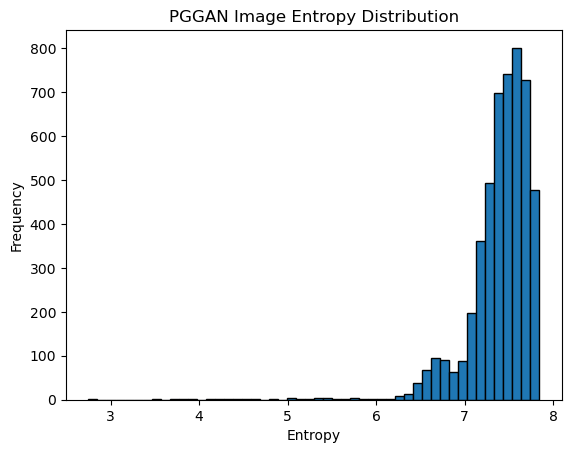

In [8]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("PGGAN Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [9]:
# PCA in latent space
from sklearn.decomposition import PCA

def compute_pca(image_paths, n_components=50, batch_size=500, target_size=(224, 224)):
    features = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i+batch_size]
        batch_imgs = []

        for path in batch:
            img = Image.open(path).convert('L').resize(target_size)
            img_arr = np.array(img, dtype=np.float32).flatten()
            batch_imgs.append(img_arr)

        batch_stack = np.stack(batch_imgs)
        features.append(batch_stack)

    all_features = np.vstack(features)
    
    # Run PCA
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(all_features)

    return pca, pca_embeddings

In [10]:
def plot_pca(pca_embeddings, title="PCA of Images"):
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5, s=5)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

In [11]:
pca_model, pggan_pca_embeddings = compute_pca(image_paths)

100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


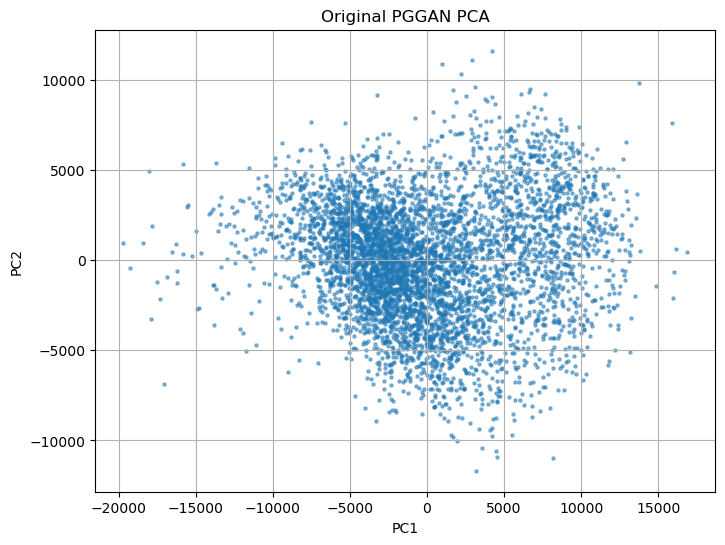

In [12]:
plot_pca(pggan_pca_embeddings, title="Original PGGAN PCA")

In [13]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(pggan_pca_embeddings, axis=0)
stds = np.std(pggan_pca_embeddings, axis=0)
skews = skew(pggan_pca_embeddings, axis=0)
pggan_kurts = kurtosis(pggan_pca_embeddings, axis=0)

pggan_pc_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(pggan_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": pggan_kurts
})

pggan_pc_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0006,5362.167480,0.2195,-0.0999
1,PC2,-0.0001,3278.339600,-0.1211,-0.0238
2,PC3,-0.0001,2872.394531,-0.0063,0.1452
3,PC4,0.0001,2795.341309,-0.1347,-0.0938
4,PC5,-0.0001,2668.430664,0.0360,-0.3041
5,PC6,-0.0006,2051.856689,-0.1066,0.1242
6,PC7,0.0002,1683.176025,-0.9354,5.1745
7,PC8,-0.0001,1474.681519,0.1482,0.6498
8,PC9,0.0001,1400.938110,-0.2598,0.9955
9,PC10,-0.0006,1291.878906,0.4619,1.1686


In [14]:
# Global averages across components

pggan_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(pggan_kurts),
    ]
}

pggan_pc_df = pd.DataFrame(pggan_pc_stats)
pggan_pc_df

,Metric,Value
0,Average Mean,-0.000017
1,Average Std Dev,1028.898560
2,Average Skew,-0.014925
3,Average Kurtosis,1.063410


## Target CNN

In [36]:
import json 
import os 

image_root = 'data/CheXpert_Sample'

with open("target_models/images/cnn_images.json", "r") as f:
    data = json.load(f)

cnn_image_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

In [37]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(cnn_image_paths)

100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


In [38]:
cnn_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

cnn_pixel_df = pd.DataFrame(cnn_pixel_stats)
cnn_pixel_df

,Metric,Value
0,Mean of Mean Image,129.121327
1,Mean of Std Dev Image,49.333801
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.963314


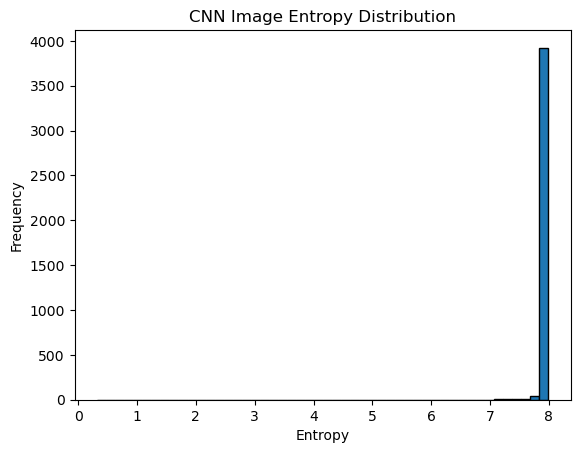

In [39]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("CNN Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [40]:
pca_model, target_cnn_pca_embeddings = compute_pca(cnn_image_paths)

100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


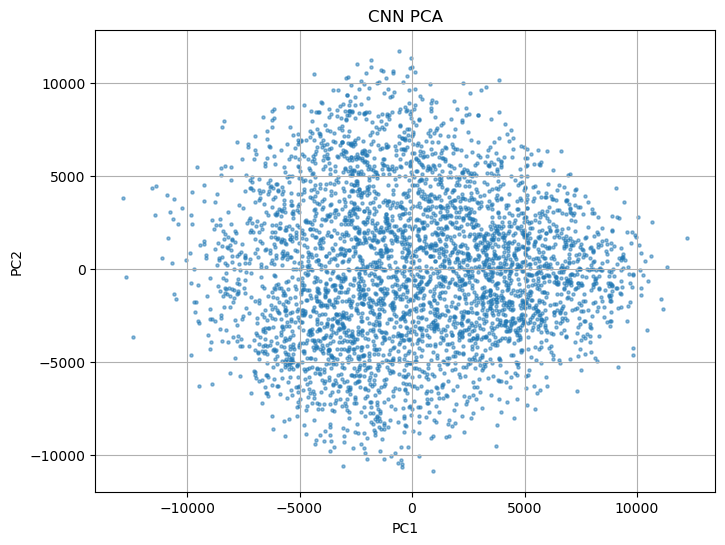

In [41]:
plot_pca(target_cnn_pca_embeddings, title="CNN PCA")

In [42]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(target_cnn_pca_embeddings, axis=0)
stds = np.std(target_cnn_pca_embeddings, axis=0)
skews = skew(target_cnn_pca_embeddings, axis=0)
cnn_kurts_target = kurtosis(target_cnn_pca_embeddings, axis=0)

cnn_pc_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(target_cnn_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": cnn_kurts_target
})

cnn_pc_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,-0.0005,4390.564453,0.0760,-0.619500
1,PC2,-0.0005,4117.654785,0.1100,-0.392300
2,PC3,-0.0001,3494.759277,-0.4065,-0.142000
3,PC4,-0.0003,2381.160400,-0.3749,0.012700
4,PC5,0.0001,2346.063721,0.2380,-0.028600
5,PC6,-0.0000,2110.470947,0.2780,0.212900
6,PC7,0.0006,1983.002563,-1.2326,4.423300
7,PC8,0.0000,1690.052246,-0.3262,0.118300
8,PC9,0.0000,1644.114624,-0.4324,1.661800
9,PC10,0.0006,1582.172607,0.2174,1.138500


In [43]:
# Global averages across components

cnn_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(cnn_kurts_target),
    ]
}

cnn_pc_df = pd.DataFrame(cnn_pc_stats)
cnn_pc_df

,Metric,Value
0,Average Mean,2.165468e-07
1,Average Std Dev,1.153099e+03
2,Average Skew,-5.148515e-02
3,Average Kurtosis,4.316180e+00


## Target Overfit CNN

In [23]:
import json 
import os 

image_root = 'data/CheXpert_Sample'

with open("target_models/images/cnn_overfit_images.json", "r") as f:
    data = json.load(f)

cnn_overfit_image_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

In [24]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(cnn_overfit_image_paths)

100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


In [25]:
cnn_overfit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

cnn_overfit_pixel_df = pd.DataFrame(cnn_overfit_pixel_stats)
cnn_overfit_pixel_df

,Metric,Value
0,Mean of Mean Image,129.215990
1,Mean of Std Dev Image,49.784545
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.964939


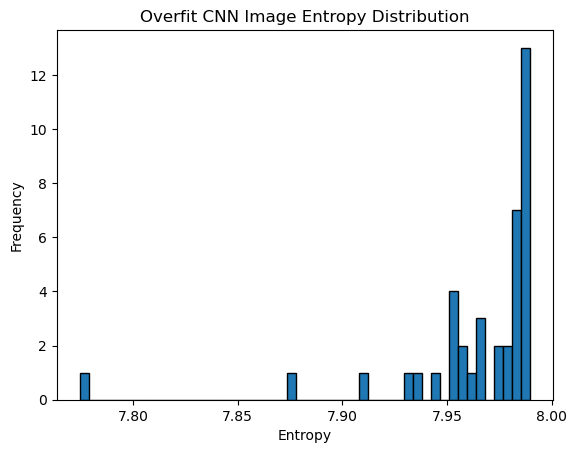

In [26]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Overfit CNN Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [27]:
# PCA in latent space
from sklearn.decomposition import PCA

def compute_pca_overfit(image_paths, n_components=20, batch_size=500, target_size=(224, 224)):
    features = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i+batch_size]
        batch_imgs = []

        for path in batch:
            img = Image.open(path).convert('L').resize(target_size)
            img_arr = np.array(img, dtype=np.float32).flatten()
            batch_imgs.append(img_arr)

        batch_stack = np.stack(batch_imgs)
        features.append(batch_stack)

    all_features = np.vstack(features)
    
    # Run PCA
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(all_features)

    return pca, pca_embeddings

In [28]:
pca_model, target_overfitcnn_pca_embeddings = compute_pca_overfit(cnn_overfit_image_paths)

100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


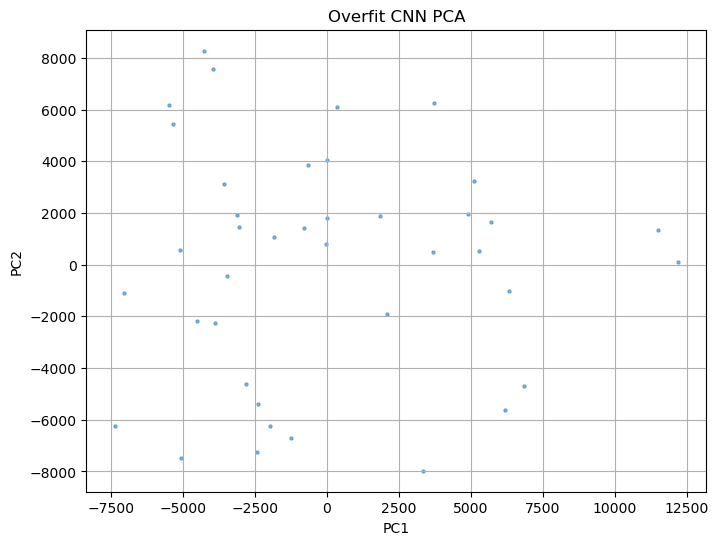

In [29]:
plot_pca(target_overfitcnn_pca_embeddings, title="Overfit CNN PCA")

In [30]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(target_overfitcnn_pca_embeddings, axis=0)
stds = np.std(target_overfitcnn_pca_embeddings, axis=0)
skews = skew(target_overfitcnn_pca_embeddings, axis=0)
cnn_overfit_kurts_target = kurtosis(target_overfitcnn_pca_embeddings, axis=0)

cnn_pc_overfit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(target_overfitcnn_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": cnn_overfit_kurts_target
})

cnn_pc_overfit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0053,4797.200684,0.6976,-0.2129
1,PC2,0.0011,4366.411133,-0.1685,-0.8068
2,PC3,-0.0001,3800.703125,0.4106,-0.3431
3,PC4,-0.0001,3103.923828,1.5847,2.7812
4,PC5,-0.0009,2838.965332,0.3453,-0.0340
5,PC6,-0.0012,2445.778320,-0.6203,1.6564
6,PC7,-0.0014,2147.993652,0.0569,-0.1394
7,PC8,-0.0006,1857.706177,0.6116,1.3769
8,PC9,-0.0026,1829.631958,-0.7487,0.5979
9,PC10,-0.0019,1782.772583,0.1792,-0.7672


In [31]:
# Global averages across components

cnn_overfit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(cnn_overfit_kurts_target),
    ]
}

cnn_overfit_pc_df = pd.DataFrame(cnn_overfit_pc_stats)
cnn_overfit_pc_df

,Metric,Value
0,Average Mean,-0.000220
1,Average Std Dev,2154.335449
2,Average Skew,0.291430
3,Average Kurtosis,0.521938


## Target Overfit CNN with features

In [32]:
import json 
import os 

image_root = 'data/CheXpert_Feats'

with open("target_models/images/feats_images.json", "r") as f:
    data = json.load(f)

feats_image_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

In [33]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(feats_image_paths)

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


In [34]:
feats_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

feats_pixel_df = pd.DataFrame(feats_pixel_stats)
feats_pixel_df

,Metric,Value
0,Mean of Mean Image,129.127424
1,Mean of Std Dev Image,49.881642
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.962505


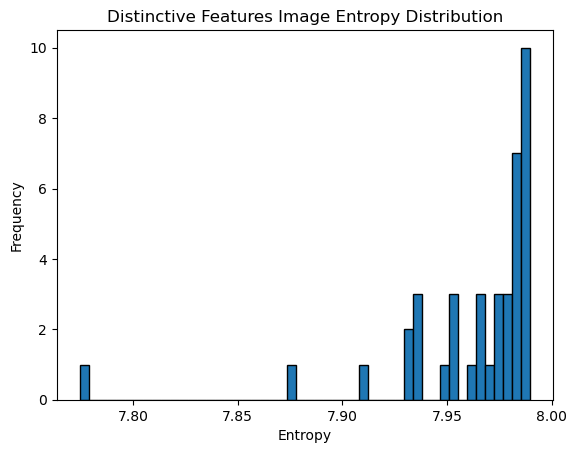

In [35]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Distinctive Features Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [43]:
Image.fromarray(mean_img.astype(np.uint8)).save("metrics/feats/mean_image.png")
Image.fromarray(std_img.astype(np.uint8)).save("metrics/feats/std_image.png")

In [36]:
pca_model, pca_embeddings = compute_pca_overfit(feats_image_paths)

100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


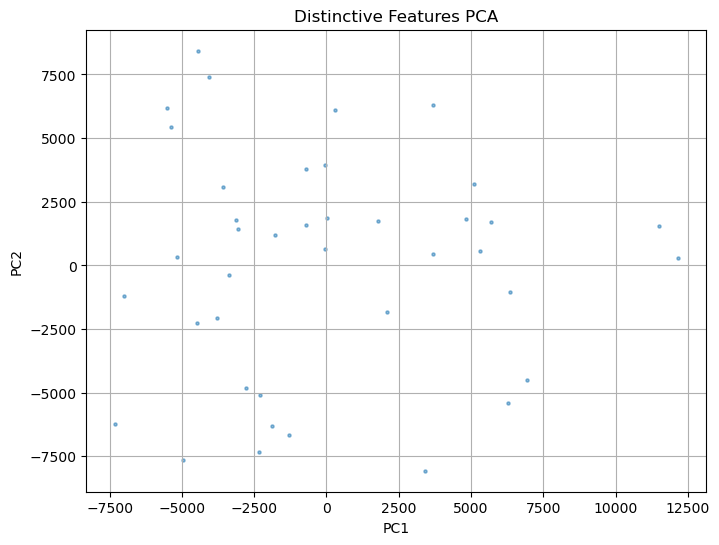

In [37]:
plot_pca(pca_embeddings, title="Distinctive Features PCA")

In [38]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(pca_embeddings, axis=0)
stds = np.std(pca_embeddings, axis=0)
skews = skew(pca_embeddings, axis=0)
kurts = kurtosis(pca_embeddings, axis=0)

feats_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": kurts
})

feats_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,-0.0037,4796.599121,0.6963,-0.2218
1,PC2,-0.0005,4356.511719,-0.1724,-0.7705
2,PC3,0.0018,3761.691895,0.4323,-0.2589
3,PC4,0.0022,3131.620605,1.6484,3.0064
4,PC5,0.0011,2834.871582,0.3384,-0.0203
5,PC6,0.0019,2436.636719,-0.6140,1.5707
6,PC7,-0.0009,2147.258057,0.1014,-0.1704
7,PC8,-0.0003,1857.071167,0.5615,1.3273
8,PC9,-0.0004,1827.906860,-0.7853,0.7120
9,PC10,-0.0005,1779.535400,0.0288,-0.9554


In [39]:
# Global averages across components

feats_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(kurts),
    ]
}

feats_pc_df = pd.DataFrame(feats_pc_stats)
feats_pc_df

,Metric,Value
0,Average Mean,0.000051
1,Average Std Dev,2155.914551
2,Average Skew,0.314437
3,Average Kurtosis,0.485555


## Target ViT

In [15]:
import json 
import os 

image_root = 'data/CheXpert_Sample'

with open("target_models/images/vit_images.json", "r") as f:
    data = json.load(f)

vit_image_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

In [16]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(vit_image_paths)

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


In [17]:
vit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

vit_pixel_df = pd.DataFrame(vit_pixel_stats)
vit_pixel_df

,Metric,Value
0,Mean of Mean Image,129.121327
1,Mean of Std Dev Image,49.333801
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.963314


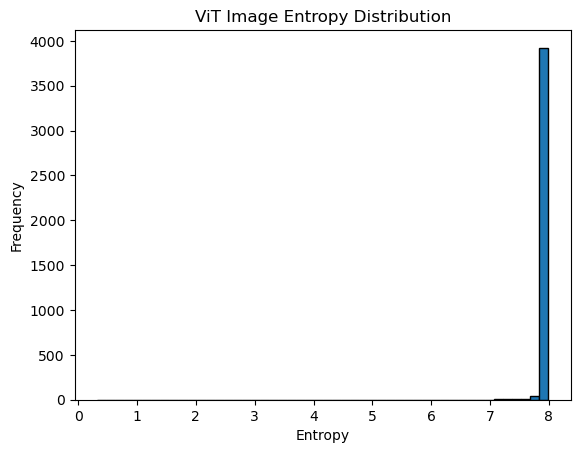

In [18]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("ViT Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [19]:
pca_model, target_vit_pca_embeddings = compute_pca(vit_image_paths)

100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


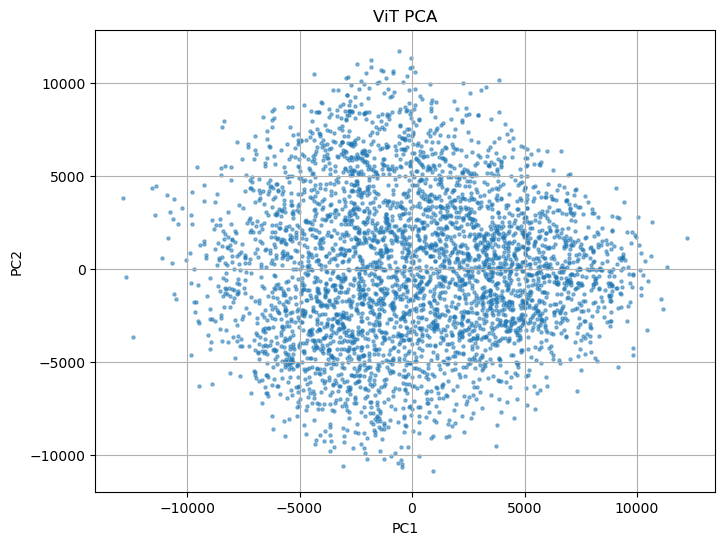

In [20]:
plot_pca(target_vit_pca_embeddings, title="ViT PCA")

In [21]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(target_vit_pca_embeddings, axis=0)
stds = np.std(target_vit_pca_embeddings, axis=0)
skews = skew(target_vit_pca_embeddings, axis=0)
vit_kurts_target = kurtosis(target_vit_pca_embeddings, axis=0)

vit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(target_vit_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": vit_kurts_target
})

vit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,-0.0002,4390.573242,0.0760,-0.619500
1,PC2,-0.0003,4117.662598,0.1100,-0.392300
2,PC3,-0.0001,3494.737549,-0.4065,-0.142000
3,PC4,-0.0001,2381.161865,-0.3750,0.012700
4,PC5,-0.0001,2346.061035,0.2379,-0.028600
5,PC6,-0.0002,2110.470215,0.2780,0.212900
6,PC7,-0.0003,1983.004028,-1.2325,4.423100
7,PC8,0.0001,1690.043945,-0.3262,0.118300
8,PC9,-0.0002,1644.113770,-0.4324,1.661800
9,PC10,-0.0003,1582.176392,0.2174,1.138500


In [22]:
# Global averages across components

vit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(vit_kurts_target),
    ]
}

vit_pc_df = pd.DataFrame(vit_pc_stats)
vit_pc_df

,Metric,Value
0,Average Mean,-0.000076
1,Average Std Dev,1153.115967
2,Average Skew,-0.053016
3,Average Kurtosis,4.296865


## Target Overfit ViT

In [40]:
import json 
import os 

image_root = 'data/CheXpert_Sample'

with open("target_models/images/vit_overfit_images.json", "r") as f:
    data = json.load(f)

vit_overfit_image_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

In [41]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(vit_overfit_image_paths)

100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


In [42]:
vit_overfit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

vit_overfit_pixel_df = pd.DataFrame(vit_overfit_pixel_stats)
vit_overfit_pixel_df

,Metric,Value
0,Mean of Mean Image,129.021912
1,Mean of Std Dev Image,49.929107
2,Min Pixel Value,0.000000
3,Max Pixel Value,255.000000
4,Average Image Entropy,7.962031


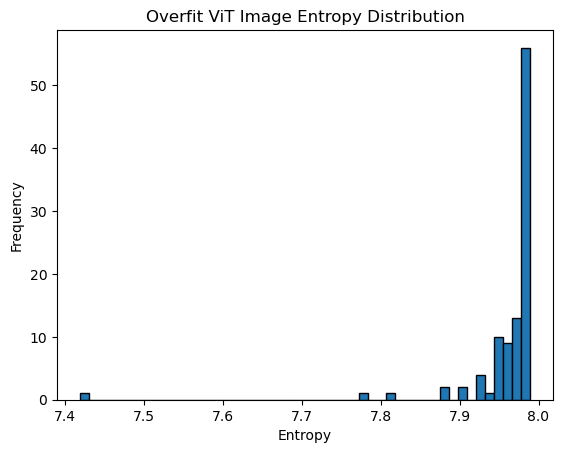

In [43]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Overfit ViT Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [44]:
pca_model, target_overfitvit_pca_embeddings = compute_pca_overfit(vit_overfit_image_paths)

100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


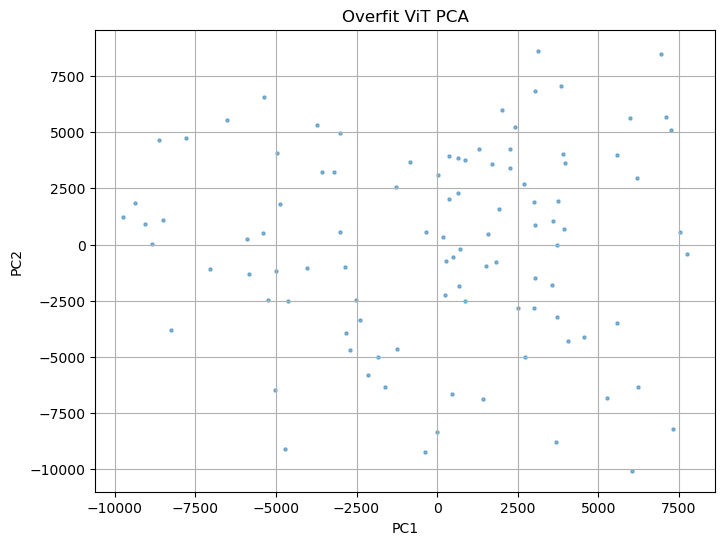

In [45]:
plot_pca(target_overfitvit_pca_embeddings, title="Overfit ViT PCA")

In [46]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(target_overfitvit_pca_embeddings, axis=0)
stds = np.std(target_overfitvit_pca_embeddings, axis=0)
skews = skew(target_overfitvit_pca_embeddings, axis=0)
overfit_vit_kurts_target = kurtosis(target_overfitvit_pca_embeddings, axis=0)

vit_overfit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(target_overfitvit_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": overfit_vit_kurts_target
})

vit_overfit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0005,4458.139648,-0.3674,-0.6856
1,PC2,-0.0005,4320.421387,-0.3270,-0.5687
2,PC3,-0.0014,3591.465088,-0.2151,-0.6092
3,PC4,-0.0012,2911.639648,-0.2413,-0.3573
4,PC5,-0.0003,2396.166992,1.2799,3.2320
5,PC6,-0.0010,2188.914551,0.2893,0.8866
6,PC7,-0.0010,2109.537598,0.5617,1.2852
7,PC8,0.0000,1866.223633,0.5472,0.3389
8,PC9,0.0002,1816.315552,-0.0515,-0.0823
9,PC10,-0.0009,1732.388550,-0.3233,0.1738


In [47]:
# Global averages across components

vit_overfit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(overfit_vit_kurts_target),
    ]
}

vit_overfit_pc_df = pd.DataFrame(vit_overfit_pc_stats)
vit_overfit_pc_df

,Metric,Value
0,Average Mean,-0.000339
1,Average Std Dev,2023.635376
2,Average Skew,0.124071
3,Average Kurtosis,0.396254


## Fine-tuned - CNN

In [44]:
import torch

cnn_tensor = torch.load('recons/cnn/cnn_classes_cand2.pt', map_location='cpu')

/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_93158/2853541738.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_tensor = torch.load('recons/cnn/cnn_class

In [45]:
cnn_tensor = (cnn_tensor + 1) / 2
cnn_tensor = torch.clamp(cnn_tensor, 0, 1)

In [3]:
import os
from torchvision.utils import save_image

output_dir = 'recons/cnn'

for idx, img in enumerate(cnn_tensor):
    save_path = os.path.join(output_dir, f"image_{idx:04d}.png")
    save_image(img, save_path)

/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [46]:
output_dir = 'recons/cnn'

cnn_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

In [47]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(cnn_image_paths)

100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


In [48]:
cnn_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

cnn_pixel_df = pd.DataFrame(cnn_pixel_stats)
cnn_pixel_df

,Metric,Value
0,Mean of Mean Image,174.356642
1,Mean of Std Dev Image,25.847816
2,Min Pixel Value,47.000000
3,Max Pixel Value,246.000000
4,Average Image Entropy,6.486116


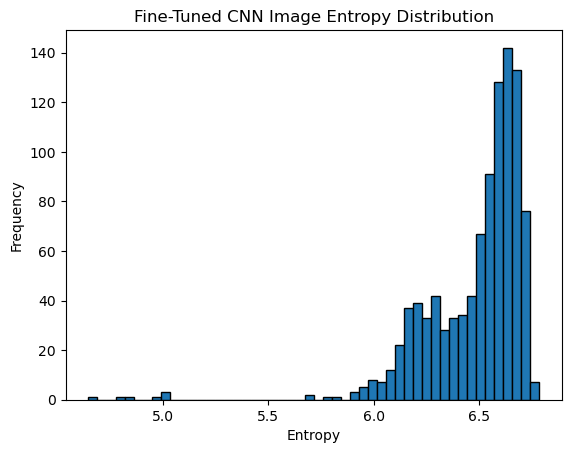

In [49]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Fine-Tuned CNN Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [50]:
pca_model, cnn_pca_embeddings = compute_pca(cnn_image_paths)

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


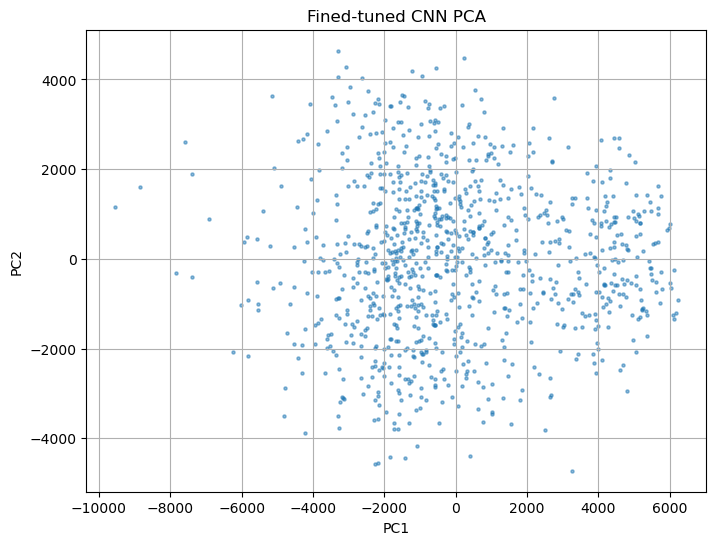

In [51]:
plot_pca(cnn_pca_embeddings, title="Fined-tuned CNN PCA")

In [52]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(cnn_pca_embeddings, axis=0)
stds = np.std(cnn_pca_embeddings, axis=0)
skews = skew(cnn_pca_embeddings, axis=0)
cnn_kurts = kurtosis(cnn_pca_embeddings, axis=0)

finetuned_cnn_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(cnn_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": cnn_kurts
})

finetuned_cnn_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0002,2769.157471,0.2786,-0.2582
1,PC2,-0.0002,1753.398560,-0.0182,-0.3851
2,PC3,-0.0001,1633.765869,0.3876,-0.1648
3,PC4,0.0003,1423.932007,-0.0645,-0.3976
4,PC5,-0.0003,1304.530029,-0.2279,-0.1855
5,PC6,0.0005,1117.771362,-0.1777,0.0384
6,PC7,-0.0001,939.428528,0.1972,0.2531
7,PC8,0.0002,809.386597,-0.1887,0.6926
8,PC9,0.0000,782.086182,-0.1590,0.6451
9,PC10,0.0000,764.514709,-0.1976,0.6144


In [53]:
# Global averages across components

finetuned_cnn_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(cnn_kurts),
    ]
}

finetuned_cnn_pc_df = pd.DataFrame(finetuned_cnn_pc_stats)
finetuned_cnn_pc_df

,Metric,Value
0,Average Mean,-0.000006
1,Average Std Dev,594.207886
2,Average Skew,-0.010490
3,Average Kurtosis,0.441249


/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_93158/1723970236.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


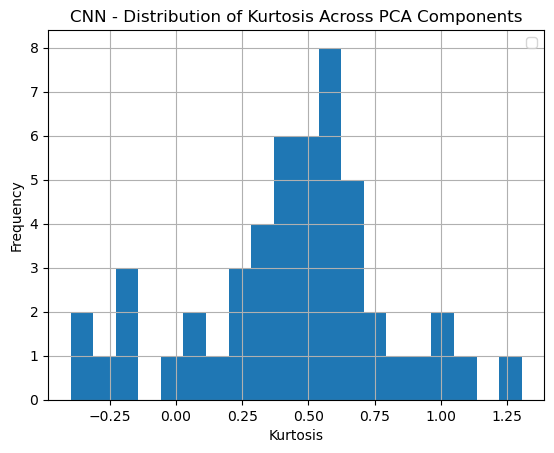

In [54]:
plt.hist(cnn_kurts, bins=20)
plt.title("CNN - Distribution of Kurtosis Across PCA Components")
plt.xlabel("Kurtosis")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
from scipy.stats import kurtosis
import numpy as np

def bootstrap_kurtosis_error(data, n_bootstrap=1000):
    n_samples, n_features = data.shape
    kurtosis_bootstrap = np.zeros((n_bootstrap, n_features))
    
    for i in range(n_bootstrap):
        sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample = data[sample_indices]
        kurtosis_bootstrap[i] = kurtosis(sample, axis=0)
    
    return np.std(kurtosis_bootstrap, axis=0)

cnn_kurtosis_std = bootstrap_kurtosis_error(cnn_pca_embeddings)
pggan_kurtosis_std = bootstrap_kurtosis_error(pggan_pca_embeddings)
target_kurtosis_std = bootstrap_kurtosis_error(target_cnn_pca_embeddings)

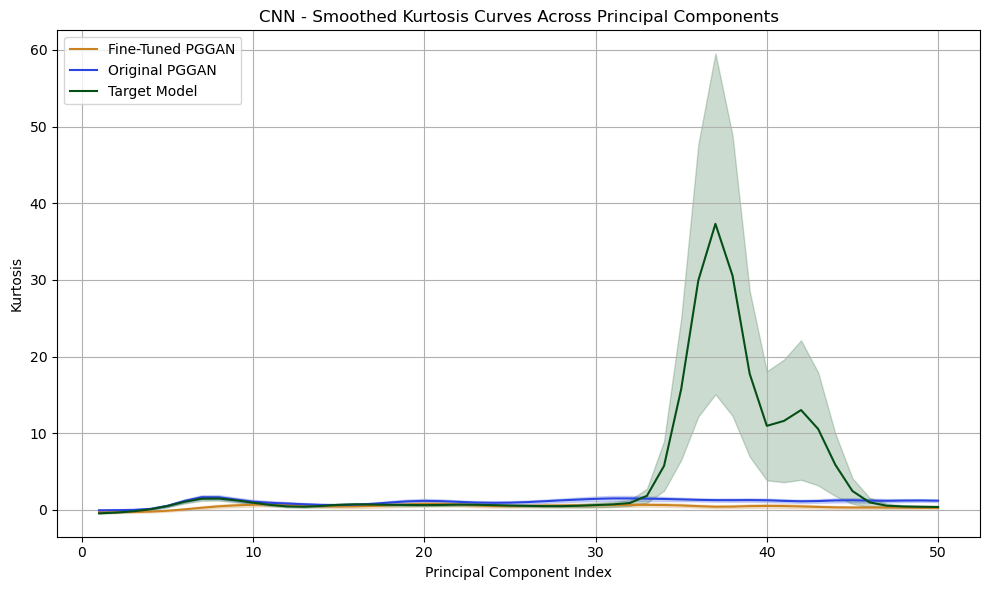

In [56]:
from scipy.ndimage import gaussian_filter1d

x = np.arange(1, len(cnn_kurts) + 1)
s_cnn = gaussian_filter1d(cnn_kurts, sigma=1.5)
s_pggan = gaussian_filter1d(pggan_kurts, sigma=1.5)
s_target = gaussian_filter1d(cnn_kurts_target, sigma=1.5)

# Smooth errors (optional for aesthetic smoothing)
s_cnn_std = gaussian_filter1d(cnn_kurtosis_std, sigma=1.5)
s_pggan_std = gaussian_filter1d(pggan_kurtosis_std, sigma=1.5)
s_target_std = gaussian_filter1d(target_kurtosis_std, sigma=1.5)

plt.figure(figsize=(10, 6), facecolor='none')

# Plot lines
plt.plot(x, s_cnn, color='#CB8221', label="Fine-Tuned PGGAN")
plt.plot(x, s_pggan, color='#2A45DF', label="Original PGGAN")
plt.plot(x, s_target, color='#044F16', label="Target Model")

# Confidence bands
plt.fill_between(x, s_cnn - s_cnn_std, s_cnn + s_cnn_std, color='#CB8221', alpha=0.2)
plt.fill_between(x, s_pggan - s_pggan_std, s_pggan + s_pggan_std, color='#2A45DF', alpha=0.2)
plt.fill_between(x, s_target - s_target_std, s_target + s_target_std, color='#044F16', alpha=0.2)

plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("CNN - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("metrics/cnn/kurtosis.png", transparent=True, dpi=300)
plt.show()

## Fine-tuned - Overfit CNN

In [64]:
cnn_overfit_tensor = torch.load('recons/cnn_overfit/cnn_overfit_cand.pt', map_location='cpu')

cnn_overfit_tensor = (cnn_overfit_tensor + 1) / 2
cnn_overfit_tensor = torch.clamp(cnn_overfit_tensor, 0, 1)

/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_92642/1981975855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_overfit_tensor = torch.load('recons/cnn_o

In [22]:
output_dir = 'recons/cnn_overfit'

for idx, img in enumerate(cnn_overfit_tensor):
    save_path = os.path.join(output_dir, f"image_{idx:04d}.png")
    save_image(img, save_path)

In [65]:
output_dir = 'recons/cnn_overfit'

cnn_overfit_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

In [66]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(cnn_overfit_image_paths)

100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


In [67]:
cnn_overfit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

cnn_overfit_pixel_df = pd.DataFrame(cnn_overfit_pixel_stats)
cnn_overfit_pixel_df

,Metric,Value
0,Mean of Mean Image,186.387716
1,Mean of Std Dev Image,19.208844
2,Min Pixel Value,70.000000
3,Max Pixel Value,240.000000
4,Average Image Entropy,6.176016


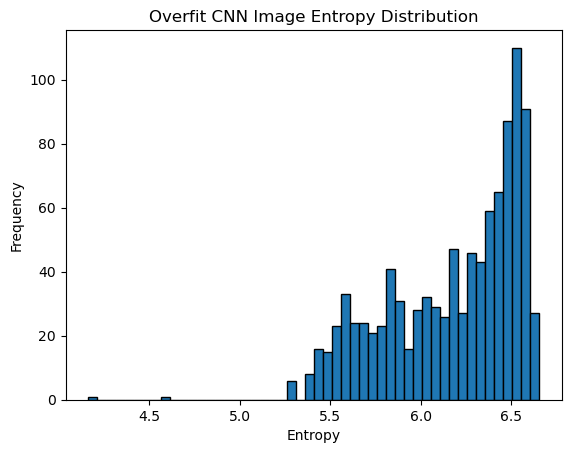

In [68]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Overfit CNN Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [69]:
pca_model, cnnoverfit_pca_embeddings = compute_pca_overfit(cnn_overfit_image_paths)

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


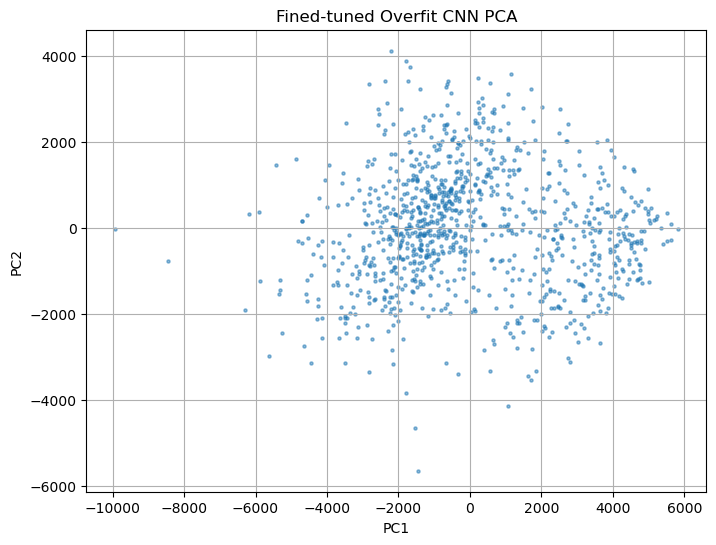

In [70]:
plot_pca(cnnoverfit_pca_embeddings, title="Fined-tuned Overfit CNN PCA")

In [73]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(cnnoverfit_pca_embeddings, axis=0)
stds = np.std(cnnoverfit_pca_embeddings, axis=0)
skews = skew(cnnoverfit_pca_embeddings, axis=0)
cnn_overfit_kurts = kurtosis(cnnoverfit_pca_embeddings, axis=0)

finetuned_cnn_overfit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(cnnoverfit_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": cnn_overfit_kurts
})

finetuned_cnn_overfit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0006,2493.963379,0.2173,-0.3338
1,PC2,-0.0001,1398.683838,-0.0143,0.1034
2,PC3,0.0004,1194.800537,0.0988,0.0289
3,PC4,-0.0001,1101.876465,-0.1464,0.4147
4,PC5,-0.0000,989.559998,0.0760,-0.2605
5,PC6,-0.0003,851.086121,-0.1121,0.2326
6,PC7,0.0002,742.658997,-0.7533,2.4428
7,PC8,-0.0002,676.141602,0.2301,0.6676
8,PC9,0.0001,617.244507,0.1964,0.5638
9,PC10,0.0001,577.948425,0.0917,0.2269


In [75]:
# Global averages across components

finetuned_cnn_overfit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(cnn_overfit_kurts),
    ]
}

finetuned_cnn_overfit_pc_df = pd.DataFrame(finetuned_cnn_overfit_pc_stats)
finetuned_cnn_overfit_pc_df

,Metric,Value
0,Average Mean,0.000052
1,Average Std Dev,750.293091
2,Average Skew,-0.004678
3,Average Kurtosis,0.566334


/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_73322/1592038435.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


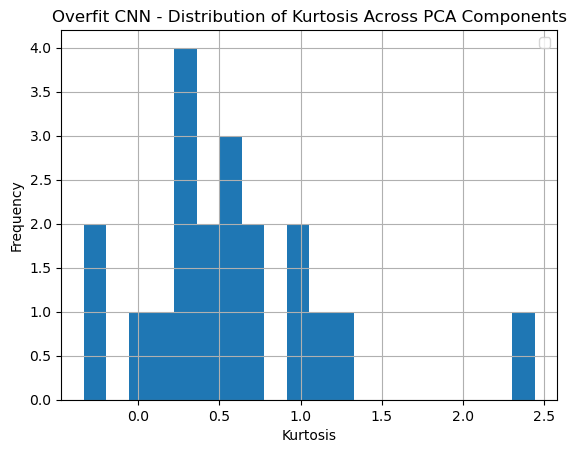

In [74]:
plt.hist(cnn_overfit_kurts, bins=20)
plt.title("Overfit CNN - Distribution of Kurtosis Across PCA Components")
plt.xlabel("Kurtosis")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

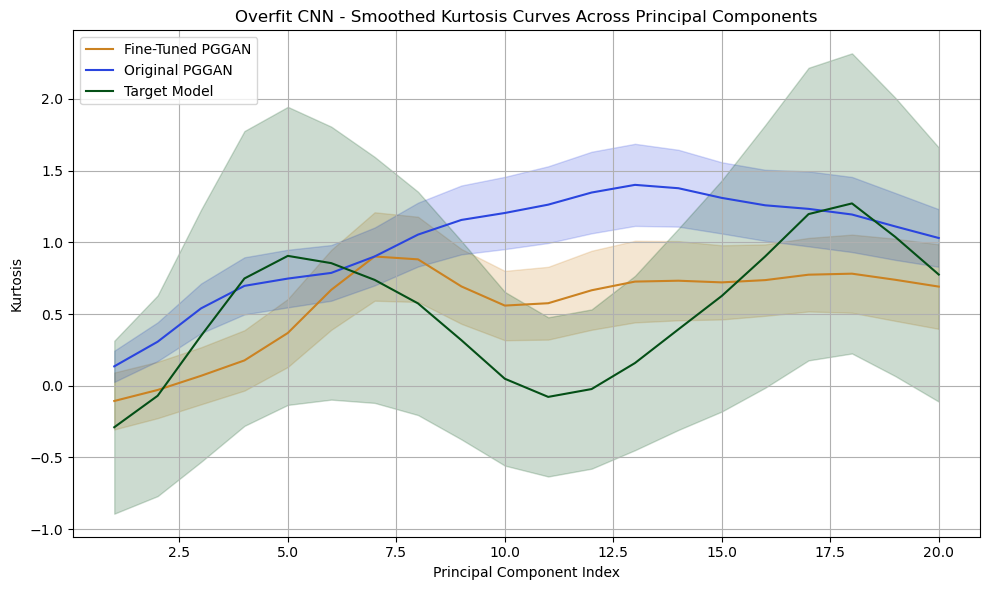

In [83]:
from scipy.stats import kurtosis
import numpy as np

def resample_array(arr, new_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, new_len)
    interpolator = interp1d(x_old, arr, kind='linear')
    return interpolator(x_new)

def bootstrap_kurtosis_error(data, n_bootstrap=1000):
    n_samples, n_features = data.shape
    kurtosis_bootstrap = np.zeros((n_bootstrap, n_features))
    
    for i in range(n_bootstrap):
        sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample = data[sample_indices]
        kurtosis_bootstrap[i] = kurtosis(sample, axis=0)
    
    return np.std(kurtosis_bootstrap, axis=0)

cnnoverfit_kurtosis_std = bootstrap_kurtosis_error(cnnoverfit_pca_embeddings)
pggan_kurtosis_std = bootstrap_kurtosis_error(pggan_pca_embeddings)
target_kurtosis_std = bootstrap_kurtosis_error(target_overfitcnn_pca_embeddings)

pggan_kurtosis_std_rs = resample_array(pggan_kurtosis_std, 20)

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

pggan_kurts_rs = resample_array(pggan_kurts, 20)

x = np.arange(1, len(cnn_overfit_kurts) + 1)
s_cnnoverfit = gaussian_filter1d(cnn_overfit_kurts, sigma=1.5)
s_pggan = gaussian_filter1d(pggan_kurts_rs, sigma=1.5)
s_target = gaussian_filter1d(cnn_overfit_kurts_target, sigma=1.5)

# Smooth errors (optional for aesthetic smoothing)
s_cnnoverfit_std = gaussian_filter1d(cnnoverfit_kurtosis_std, sigma=1.5)
s_pggan_std = gaussian_filter1d(pggan_kurtosis_std_rs, sigma=1.5)
s_target_std = gaussian_filter1d(target_kurtosis_std, sigma=1.5)

plt.figure(figsize=(10, 6), facecolor='none')

# Plot lines
plt.plot(x, s_cnnoverfit, color='#CB8221', label="Fine-Tuned PGGAN")
plt.plot(x, s_pggan, color='#2A45DF', label="Original PGGAN")
plt.plot(x, s_target, color='#044F16', label="Target Model")

# Confidence bands
plt.fill_between(x, s_cnnoverfit - s_cnnoverfit_std, s_cnnoverfit + s_cnnoverfit_std, color='#CB8221', alpha=0.2)
plt.fill_between(x, s_pggan - s_pggan_std, s_pggan + s_pggan_std, color='#2A45DF', alpha=0.2)
plt.fill_between(x, s_target - s_target_std, s_target + s_target_std, color='#044F16', alpha=0.2)

plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("Overfit CNN - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig("metrics/cnn_overfit/kurtosis2.png", transparent=True, dpi=300)
plt.show()

## Fine-tuned - ViT

In [24]:
import torch

vit_tensor = torch.load('recons/vit/vit_cand.pt', map_location='cpu')

vit_tensor = (vit_tensor + 1) / 2
vit_tensor = torch.clamp(vit_tensor, 0, 1)

/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_93158/2547867855.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_tensor = torch.load('recons/vit/vit_cand.

In [34]:
output_dir = 'recons/vit'

for idx, img in enumerate(vit_tensor):
    save_path = os.path.join(output_dir, f"image_{idx:04d}.png")
    save_image(img, save_path)

In [25]:
output_dir = 'recons/vit'

vit_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

In [26]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(vit_image_paths)

100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


In [27]:
vit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

vit_pixel_df = pd.DataFrame(vit_pixel_stats)
vit_pixel_df

,Metric,Value
0,Mean of Mean Image,183.974690
1,Mean of Std Dev Image,19.773611
2,Min Pixel Value,73.000000
3,Max Pixel Value,239.000000
4,Average Image Entropy,6.176308


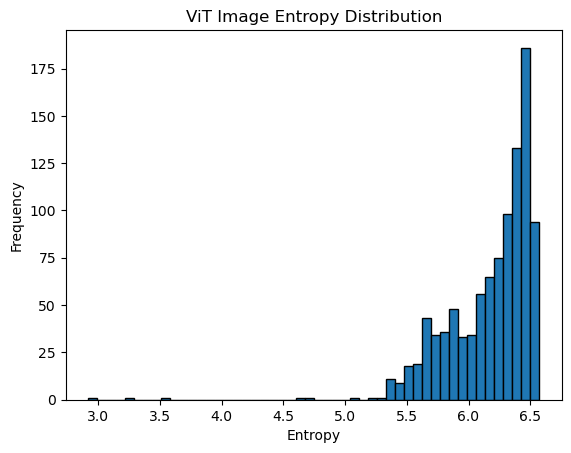

In [28]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("ViT Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [29]:
pca_model, vit_pca_embeddings = compute_pca(vit_image_paths)

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


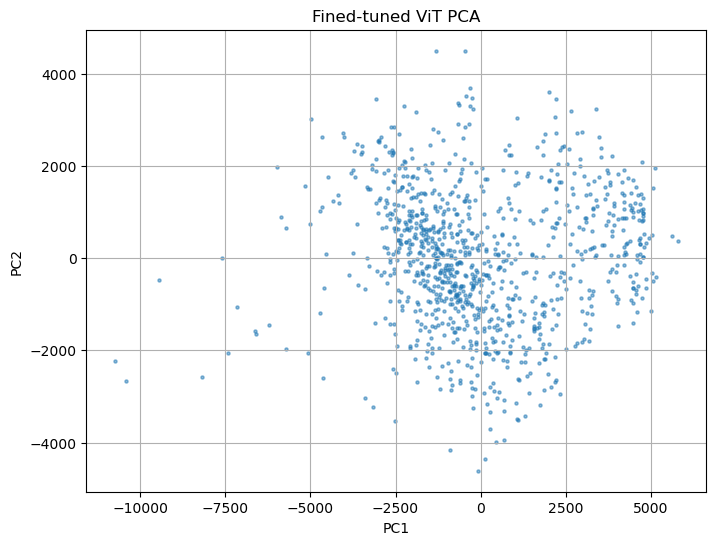

In [30]:
plot_pca(vit_pca_embeddings, title="Fined-tuned ViT PCA")

In [31]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(vit_pca_embeddings, axis=0)
stds = np.std(vit_pca_embeddings, axis=0)
skews = skew(vit_pca_embeddings, axis=0)
vit_kurts = kurtosis(vit_pca_embeddings, axis=0)

finetuned_vit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(vit_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": vit_kurts
})

finetuned_vit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,-0.0007,2448.503418,0.0349,0.4934
1,PC2,0.0005,1472.911377,-0.0644,-0.1684
2,PC3,0.0000,1255.111084,0.0032,-0.3128
3,PC4,-0.0003,1123.753418,0.5914,1.7147
4,PC5,0.0001,1060.672974,-0.3338,0.7454
5,PC6,0.0000,905.640381,0.1023,0.2412
6,PC7,0.0001,780.817627,-0.9969,3.3593
7,PC8,0.0001,665.670105,0.0326,0.1123
8,PC9,0.0001,611.849609,0.1754,0.0260
9,PC10,-0.0001,576.387207,0.7593,4.3577


In [32]:
# Global averages across components

finetuned_vit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(vit_kurts),
    ]
}

finetuned_vit_pc_df = pd.DataFrame(finetuned_vit_pc_stats)
finetuned_vit_pc_df

,Metric,Value
0,Average Mean,0.000012
1,Average Std Dev,458.751709
2,Average Skew,0.014218
3,Average Kurtosis,0.987123


/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_93158/2947978948.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


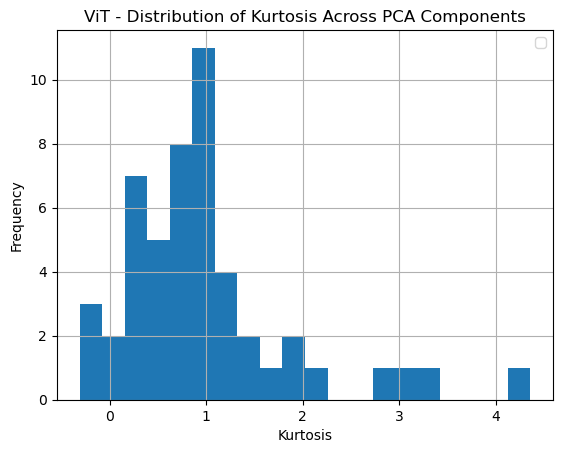

In [33]:
plt.hist(vit_kurts, bins=20)
plt.title("ViT - Distribution of Kurtosis Across PCA Components")
plt.xlabel("Kurtosis")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

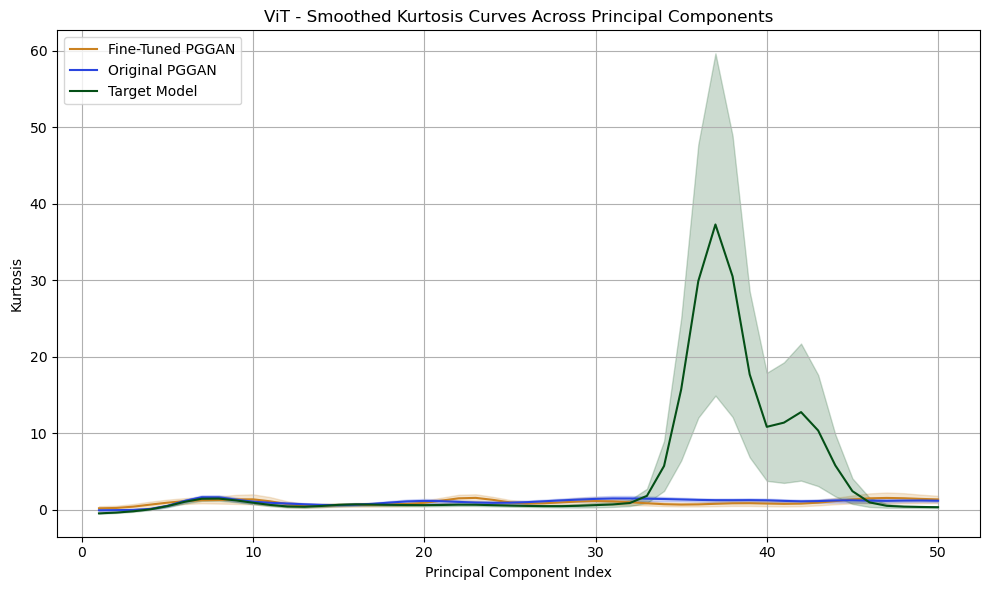

In [35]:
from scipy.stats import kurtosis
import numpy as np

def bootstrap_kurtosis_error(data, n_bootstrap=1000):
    n_samples, n_features = data.shape
    kurtosis_bootstrap = np.zeros((n_bootstrap, n_features))
    
    for i in range(n_bootstrap):
        sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample = data[sample_indices]
        kurtosis_bootstrap[i] = kurtosis(sample, axis=0)
    
    return np.std(kurtosis_bootstrap, axis=0)

vit_kurtosis_std = bootstrap_kurtosis_error(vit_pca_embeddings)
pggan_kurtosis_std = bootstrap_kurtosis_error(pggan_pca_embeddings)
target_kurtosis_std = bootstrap_kurtosis_error(target_vit_pca_embeddings)

from scipy.ndimage import gaussian_filter1d

x = np.arange(1, len(vit_kurts) + 1)
s_vit = gaussian_filter1d(vit_kurts, sigma=1.5)
s_pggan = gaussian_filter1d(pggan_kurts, sigma=1.5)
s_target = gaussian_filter1d(vit_kurts_target, sigma=1.5)

# Smooth errors (optional for aesthetic smoothing)
s_vit_std = gaussian_filter1d(vit_kurtosis_std, sigma=1.5)
s_pggan_std = gaussian_filter1d(pggan_kurtosis_std, sigma=1.5)
s_target_std = gaussian_filter1d(target_kurtosis_std, sigma=1.5)

plt.figure(figsize=(10, 6), facecolor='none')

# Plot lines
plt.plot(x, s_vit, color='#CB8221', label="Fine-Tuned PGGAN")
plt.plot(x, s_pggan, color='#2A45DF', label="Original PGGAN")
plt.plot(x, s_target, color='#044F16', label="Target Model")

# Confidence bands
plt.fill_between(x, s_vit - s_vit_std, s_vit + s_vit_std, color='#CB8221', alpha=0.2)
plt.fill_between(x, s_pggan - s_pggan_std, s_pggan + s_pggan_std, color='#2A45DF', alpha=0.2)
plt.fill_between(x, s_target - s_target_std, s_target + s_target_std, color='#044F16', alpha=0.2)

plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("ViT - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("metrics/vit/kurtosis.png", transparent=True, dpi=300)
plt.show()

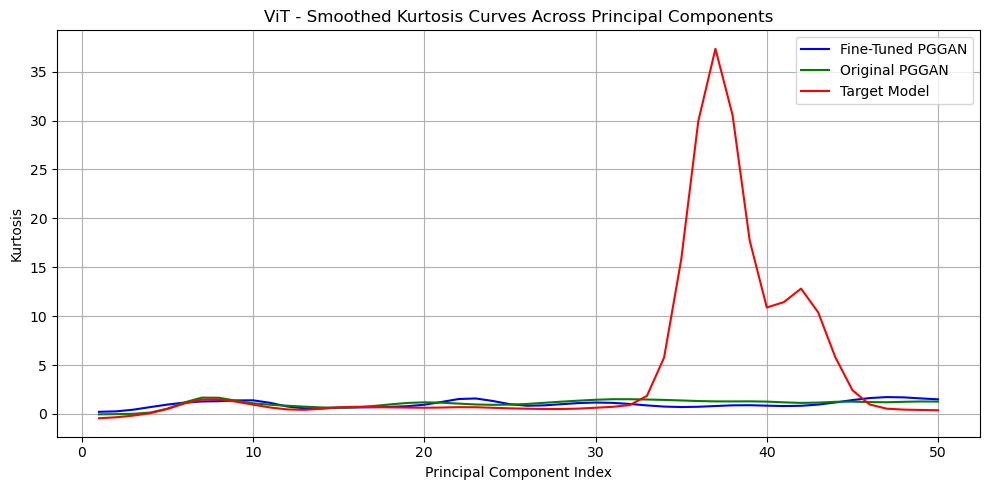

In [85]:
from scipy.ndimage import gaussian_filter1d

smoothed_kurtosis_ft = gaussian_filter1d(vit_kurts, sigma=1.5)
smoothed_kurtosis_pggan = gaussian_filter1d(pggan_kurts, sigma=1.5)
smoothed_kurtosis_target = gaussian_filter1d(vit_kurts_target, sigma=1.5)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(vit_kurts) + 1), smoothed_kurtosis_ft, color='blue', label="Fine-Tuned PGGAN")
plt.plot(range(1, len(vit_kurts) + 1), smoothed_kurtosis_pggan, color='green', label="Original PGGAN")
plt.plot(range(1, len(vit_kurts) + 1), smoothed_kurtosis_target, color='red', label="Target Model")
plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("ViT - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Fine-tuned - Overfit ViT

In [84]:
vit_overfit_tensor = torch.load('recons/vit_overfit/vit_overfit_cand.pt', map_location='cpu')

vit_overfit_tensor = (vit_overfit_tensor + 1) / 2
vit_overfit_tensor = torch.clamp(vit_overfit_tensor, 0, 1)

/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_92642/1793628288.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_overfit_tensor = torch.load('recons/vit_o

In [47]:
output_dir = 'recons/vit_overfit'

for idx, img in enumerate(vit_overfit_tensor):
    save_path = os.path.join(output_dir, f"image_{idx:04d}.png")
    save_image(img, save_path)

In [85]:
output_dir = 'recons/vit_overfit'

vit_overfit_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

In [86]:
mean_img, std_img, min_img, max_img, entropies = compute_pixel_stats(vit_overfit_image_paths)

100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [87]:
vit_overfit_pixel_stats = {
    "Metric": [
        "Mean of Mean Image",
        "Mean of Std Dev Image",
        "Min Pixel Value",
        "Max Pixel Value",
        "Average Image Entropy"
    ],
    "Value": [
        np.mean(mean_img),
        np.mean(std_img),
        np.min(min_img),
        np.max(max_img),
        np.mean(entropies)
    ]
}

vit_overfit_pixel_df = pd.DataFrame(vit_overfit_pixel_stats)
vit_overfit_pixel_df

,Metric,Value
0,Mean of Mean Image,184.277936
1,Mean of Std Dev Image,18.549145
2,Min Pixel Value,79.000000
3,Max Pixel Value,241.000000
4,Average Image Entropy,6.124661


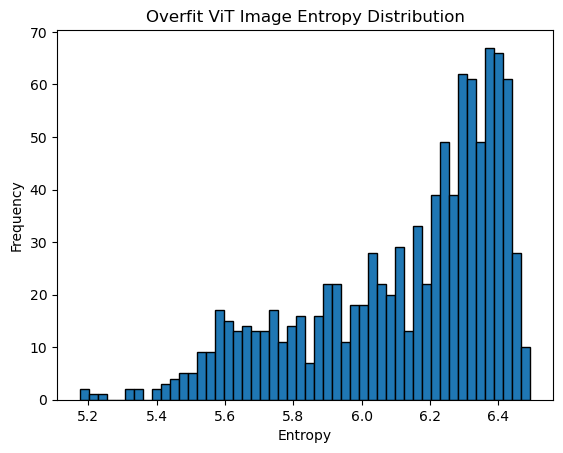

In [88]:
# Entropy histogram
import matplotlib.pyplot as plt

plt.hist(entropies, bins=50, edgecolor='black')
plt.title("Overfit ViT Image Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [89]:
pca_model, overfitvit_pca_embeddings = compute_pca_overfit(vit_overfit_image_paths)

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


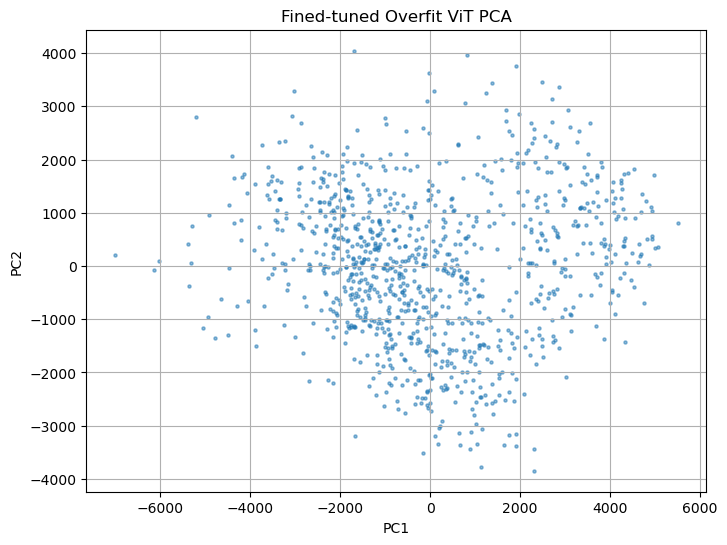

In [90]:
plot_pca(overfitvit_pca_embeddings, title="Fined-tuned Overfit ViT PCA")

In [91]:
# Compute stats for each PC
import numpy as np 
from scipy.stats import skew, kurtosis 
import pandas as pd 

# Initialize
means = np.mean(overfitvit_pca_embeddings, axis=0)
stds = np.std(overfitvit_pca_embeddings, axis=0)
skews = skew(overfitvit_pca_embeddings, axis=0)
vit_kurts = kurtosis(overfitvit_pca_embeddings, axis=0)

finetuned_vit_overfit_stats = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(overfitvit_pca_embeddings.shape[1])],
    "Mean": means, 
    "Std Dev": stds,
    "Skewness": skews,
    "Kurtosis": vit_kurts
})

finetuned_vit_overfit_stats.round(4)

,PC,Mean,Std Dev,Skewness,Kurtosis
0,PC1,0.0004,2218.526611,0.2070,-0.3872
1,PC2,-0.0002,1401.751343,-0.0941,-0.3049
2,PC3,0.0001,1225.783447,-0.0486,-0.1218
3,PC4,0.0001,1077.052002,0.0620,-0.4305
4,PC5,-0.0002,995.894592,0.1676,0.0898
5,PC6,0.0002,865.128113,0.0103,-0.3236
6,PC7,-0.0001,661.403992,-0.9083,2.8516
7,PC8,0.0001,630.999207,0.1695,0.7316
8,PC9,-0.0000,617.960876,0.0215,-0.1359
9,PC10,0.0001,576.677429,-0.0021,2.0981


In [92]:
# Global averages across components

finetuned_vit_overfit_pc_stats = {
    "Metric": [
        "Average Mean",
        "Average Std Dev",
        "Average Skew",
        "Average Kurtosis",
    ],
    "Value": [
        np.mean(means),
        np.mean(stds),
        np.mean(skews),
        np.mean(vit_kurts),
    ]
}

finetuned_vit_overfit_pc_df = pd.DataFrame(finetuned_vit_overfit_pc_stats)
finetuned_vit_overfit_pc_df

,Metric,Value
0,Average Mean,0.000039
1,Average Std Dev,730.161011
2,Average Skew,-0.048168
3,Average Kurtosis,0.579832


/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_92642/45500284.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


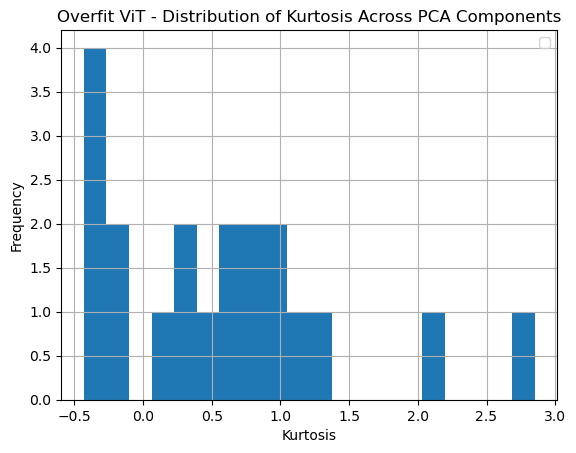

In [93]:
plt.hist(vit_kurts, bins=20)
plt.title("Overfit ViT - Distribution of Kurtosis Across PCA Components")
plt.xlabel("Kurtosis")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

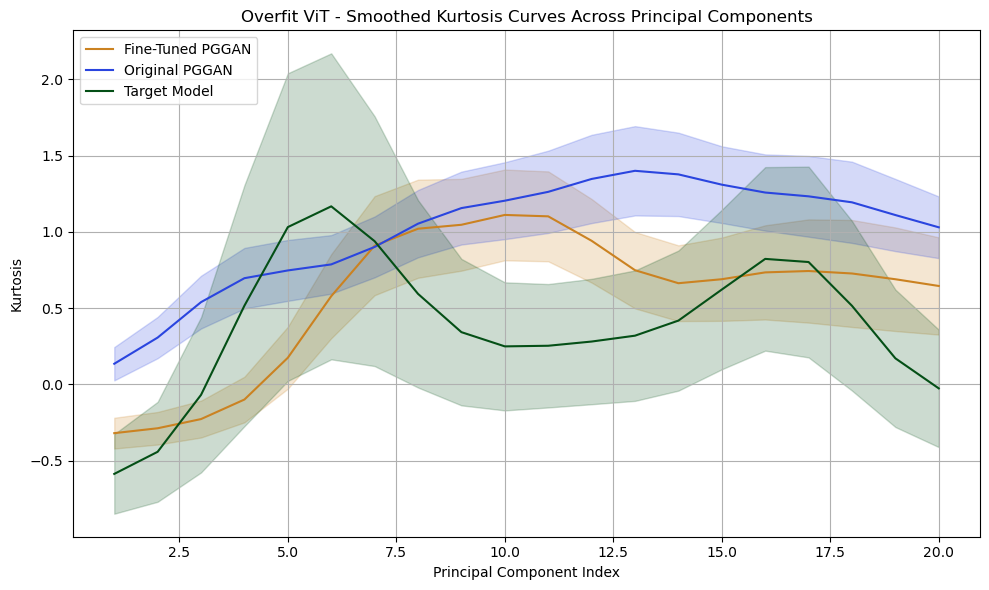

In [94]:
from scipy.stats import kurtosis
import numpy as np

def resample_array(arr, new_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, new_len)
    interpolator = interp1d(x_old, arr, kind='linear')
    return interpolator(x_new)

def bootstrap_kurtosis_error(data, n_bootstrap=1000):
    n_samples, n_features = data.shape
    kurtosis_bootstrap = np.zeros((n_bootstrap, n_features))
    
    for i in range(n_bootstrap):
        sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample = data[sample_indices]
        kurtosis_bootstrap[i] = kurtosis(sample, axis=0)
    
    return np.std(kurtosis_bootstrap, axis=0)

overfitvit_kurtosis_std = bootstrap_kurtosis_error(overfitvit_pca_embeddings)
pggan_kurtosis_std = bootstrap_kurtosis_error(pggan_pca_embeddings)
target_kurtosis_std = bootstrap_kurtosis_error(target_overfitvit_pca_embeddings)

pggan_kurtosis_std_rs = resample_array(pggan_kurtosis_std, 20)

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

pggan_kurts_rs = resample_array(pggan_kurts, 20)

x = np.arange(1, len(vit_kurts) + 1)
s_vitoverfit = gaussian_filter1d(vit_kurts, sigma=1.5)
s_pggan = gaussian_filter1d(pggan_kurts_rs, sigma=1.5)
s_target = gaussian_filter1d(overfit_vit_kurts_target, sigma=1.5)

# Smooth errors (optional for aesthetic smoothing)
s_vitoverfit_std = gaussian_filter1d(overfitvit_kurtosis_std, sigma=1.5)
s_pggan_std = gaussian_filter1d(pggan_kurtosis_std_rs, sigma=1.5)
s_target_std = gaussian_filter1d(target_kurtosis_std, sigma=1.5)

plt.figure(figsize=(10, 6), facecolor='none')

# Plot lines
plt.plot(x, s_vitoverfit, color='#CB8221', label="Fine-Tuned PGGAN")
plt.plot(x, s_pggan, color='#2A45DF', label="Original PGGAN")
plt.plot(x, s_target, color='#044F16', label="Target Model")

# Confidence bands
plt.fill_between(x, s_vitoverfit - s_vitoverfit_std, s_vitoverfit + s_vitoverfit_std, color='#CB8221', alpha=0.2)
plt.fill_between(x, s_pggan - s_pggan_std, s_pggan + s_pggan_std, color='#2A45DF', alpha=0.2)
plt.fill_between(x, s_target - s_target_std, s_target + s_target_std, color='#044F16', alpha=0.2)

plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("Overfit ViT - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("metrics/vit_overfit/kurtosis.png", transparent=True, dpi=300)
plt.show()

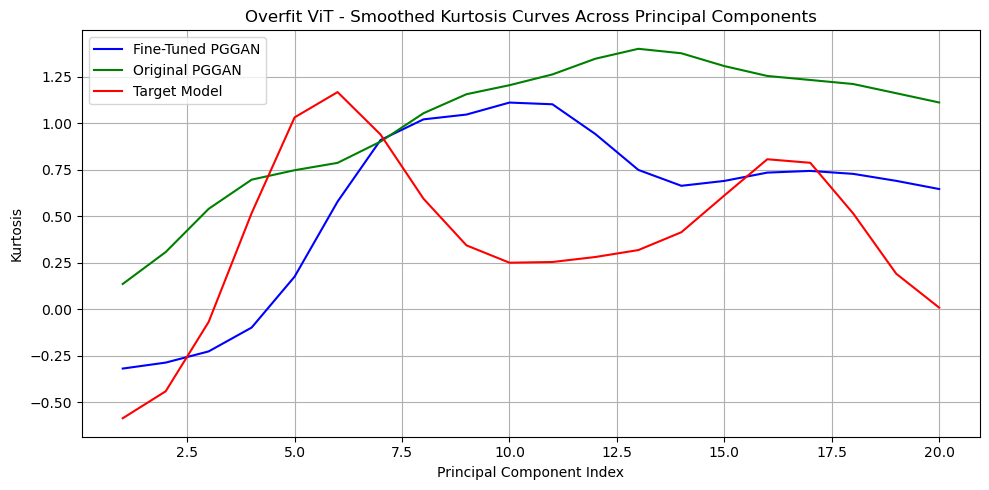

In [95]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

def resample_array(arr, new_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, new_len)
    interpolator = interp1d(x_old, arr, kind='linear')
    return interpolator(x_new)

pggan_kurts_rs = resample_array(pggan_kurts, 20)

smoothed_kurtosis_ft = gaussian_filter1d(vit_kurts, sigma=1.5)
smoothed_kurtosis_pggan = gaussian_filter1d(pggan_kurts_rs, sigma=1.5)
smoothed_kurtosis_target = gaussian_filter1d(overfit_vit_kurts_target, sigma=1.5)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(kurts) + 1), smoothed_kurtosis_ft, color='blue', label="Fine-Tuned PGGAN")
plt.plot(range(1, len(kurts) + 1), smoothed_kurtosis_pggan, color='green', label="Original PGGAN")
plt.plot(range(1, len(kurts) + 1), smoothed_kurtosis_target, color='red', label="Target Model")
plt.xlabel("Principal Component Index")
plt.ylabel("Kurtosis")
plt.title("Overfit ViT - Smoothed Kurtosis Curves Across Principal Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## FID

To further compare distributions, we use Fréchet Inception Distance (FID) to measure the distance between 2 distributions in feature space.

Distribution comparisons
- Original PGGAN $\rightarrow$ Fine-tuned PGGAN
- Fine-tuned PGGAN $\rightarrow$ Target model

In [33]:
import torch 
import torchvision.transforms as T 
import torchvision.models as models
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
from scipy.linalg import sqrtm 
import numpy as np
from tqdm import tqdm 
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [34]:
# Preprocessing transform 

transform = T.Compose([
    T.Resize((299, 299)), # InceptionV3 requirement
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3) # Normalize to [-1, 1]
])

In [35]:
# Load pretrained InceptionV3 feature layer
from torchvision.models import Inception_V3_Weights

inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False)
inception.fc = torch.nn.Identity() # remove classifier
inception.eval().to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [36]:
@torch.no_grad()
def get_activations(image_paths, model, batch_size=32):
    activations = []
    n = len(image_paths)

    for i in tqdm(range(0, n, batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = []

        for path in batch_paths:
            img = Image.open(path).convert('RGB')
            img_tensor = transform(img)
            batch_imgs.append(img_tensor)

        batch_tensor = torch.stack(batch_imgs).to(device)
        preds = model(batch_tensor)
        activations.append(preds.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    return activations 

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2 
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if not np.isfinite(covmean).all():
        print("Warning: fid calculation produced non-finite values. Adding eps to diagonal.")
        offset = np.eye(sigma1.shape[0]) * eps 
        covmean = sqrtm((sigma1 + offset) @ (sigma2 + offset))

    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_fid(target_paths, recon_paths, batch_size=32):
    # Load datasets
    target_acts = get_activations(target_paths, inception, batch_size=batch_size)
    recon_acts = get_activations(recon_paths, inception, batch_size=batch_size)

    # Compute stats
    mu_target, sigma_target = target_acts.mean(axis=0), np.cov(target_acts, rowvar=False)
    mu_recon, sigma_recon = recon_acts.mean(axis=0), np.cov(recon_acts, rowvar=False)

    # Compute FID
    fid_value = calculate_fid(mu_target, sigma_target, mu_recon, sigma_recon)
    return fid_value

In [37]:
# Original PGGAN -> Fine-tuned PGGAN on CNN

# Original PGGAN image paths
pggan_paths = sample_df['Path'].tolist()

# Fine-tuned PGGAN image paths
output_dir = 'recons/cnn'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Compute FID
fid_score = compute_fid(pggan_paths, finetuned_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


FID score: 159.9088


In [106]:
# Original PGGAN -> Fine-tuned PGGAN on Overfit CNN

# Original PGGAN image paths
pggan_paths = sample_df['Path'].tolist()

# Fine-tuned PGGAN image paths
output_dir = 'recons/cnn_overfit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Compute FID
fid_score = compute_fid(pggan_paths, finetuned_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


FID score: 95.5836


In [107]:
# Original PGGAN -> Fine-tuned PGGAN on ViT

# Original PGGAN image paths
pggan_paths = sample_df['Path'].tolist()

# Fine-tuned PGGAN image paths
output_dir = 'recons/vit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Compute FID
fid_score = compute_fid(pggan_paths, finetuned_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


FID score: 74.7530


In [108]:
# Original PGGAN -> Fine-tuned PGGAN on Overfit ViT

# Original PGGAN image paths
pggan_paths = sample_df['Path'].tolist()

# Fine-tuned PGGAN image paths
output_dir = 'recons/vit_overfit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Compute FID
fid_score = compute_fid(pggan_paths, finetuned_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


FID score: 90.0923


In [38]:
# Fine-tuned PGGAN on CNN -> Target CNN

# Fine-tuned PGGAN image paths
output_dir = 'recons/cnn'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Target paths
image_root = 'data/CheXpert_Sample'
with open("target_models/images/cnn_images.json", "r") as f:
    data = json.load(f)
target_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

# Compute FID
fid_score = compute_fid(finetuned_paths, target_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:25<00:00,  5.00it/s]


FID score: 178.9562


In [110]:
# Fine-tuned PGGAN on Overfit CNN -> Target Overfit CNN

# Fine-tuned PGGAN image paths
output_dir = 'recons/cnn_overfit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Target paths
image_root = 'data/CheXpert_Sample'
with open("target_models/images/cnn_overfit_images.json", "r") as f:
    data = json.load(f)
target_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

# Compute FID
fid_score = compute_fid(finetuned_paths, target_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


FID score: 198.1082


In [111]:
# Fine-tuned PGGAN on ViT -> Target ViT

# Fine-tuned PGGAN image paths
output_dir = 'recons/vit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Target paths
image_root = 'data/CheXpert_Sample'
with open("target_models/images/vit_images.json", "r") as f:
    data = json.load(f)
target_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

# Compute FID
fid_score = compute_fid(finetuned_paths, target_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 125/125 [00:25<00:00,  5.00it/s]


FID score: 104.9406


In [112]:
# Fine-tuned PGGAN on Overfit ViT -> Target Overfit ViT

# Fine-tuned PGGAN image paths
output_dir = 'recons/vit_overfit'
finetuned_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(".png")]

# Target paths
image_root = 'data/CheXpert_Sample'
with open("target_models/images/vit_overfit_images.json", "r") as f:
    data = json.load(f)
target_paths = [os.path.join(image_root, entry["Path"]) for entry in data]

# Compute FID
fid_score = compute_fid(finetuned_paths, target_paths, batch_size=32)
print(f"FID score: {fid_score:.4f}")

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


FID score: 171.7221
